In [ ]:
!pip install bidict
!pip install pixiedust
import nltk
nltk.download('punkt')

     |████████████████████████████████| 204kB 4.4MB/s 
     |████████████████████████████████| 1.0MB 10.6MB/s 
  Created wheel for pixiedust: filename=pixiedust-1.1.18-cp36-none-any.whl size=321727 sha256=61f9a60e9b656796f762b9fee390a1d3fd892a5665831c18f46da4dd4cba2d39
  Stored in directory: /root/.cache/pip/wheels/e8/b1/86/c2f2e16e6bf9bfe556f9dbf8adb9f41816c476d73078c7d0eb
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364064 sha256=a28ce9ae48d7ac4439efe2756b92af7c049e7e3ec8c29d118824f107a8e6d178
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built pixiedust mpld3
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import random
import re, os, difflib
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Bidirectional, Concatenate
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from nltk import word_tokenize
from gensim.models import Word2Vec
from sklearn.preprocessing import OneHotEncoder
from bidict import bidict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

# selections

In [ ]:
colab=True
training=True
validation=True
filename='fra.csv'
weight_file='fra.hdf5'

# Hyperparams

In [ ]:
# either length or list of index such as range(1, 2200)
training_samples=15000
dropout=0.2
ctx_vec_len=128
embedding_dim=128
epochs=300
# if running on colab turn this false, and select GPU runtime
batch_size=32 if not tf.test.is_gpu_available() else 2048

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Architecture For Neural Machine Trans
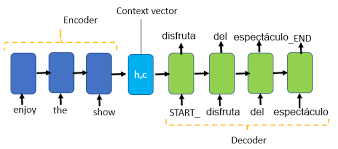

In [ ]:
from IPython.display import display, Markdown
if not colab:
    display(Markdown('''## Architecture For Neural Machine Trans
![Architecture Neural Machine Trans](image/NeuralMachineTrans.jpg)'''))
    
else:
    display(Markdown('''## Architecture For Neural Machine Trans
![Architecture Neural Machine Trans](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAVIAAACVCAMAAAA9kYJlAAABa1BMVEX///+S0FBEcsQAsPAAAACU004oW638/Py+vr7Pz8/39/f/3ZrY2ur/0GcAs/Pa3uYAb7OU1EhrpF1BccagqsI4a8AAgMP/7s//vQDl5vLv7+9tiZzs6+/j4+NhmmJNg2t1jKVGe26DwU+Ol7W2vc/IztopVZ1VcKd+u1LZ2dmMlsDKzeJzrlmutNKhoaG3vNdRUVFtbW1eXl59fX1qamq1tbWmpqZ3d3eLi4tHR0c3NzeXl5e5ubklJSUxMTEfHx9fg4sTExP/xiH/9eMyvPL/8s3/9+L/6sB6j7dge64AnN85X6Pf9P3/zVr/3oz/2G//56j/y0X/13dJaKRLS1KusL1FR2AAADJTc3t+mKomOyBSf0phlG9gjIORortkmWkARplRg7ZcgzJEYCVUg3yK0va8wc5/hI4SHjMJEiEwUIo6UiN2qEAxMlI6VzolQHC14vljyPUzLzgeN2JqgqQvRz9hYnOJj6xfZYZlJtHGAAAShElEQVR4nO2djX/UNprHBShYErRsgGyCiCgNoaCD9fpNfpM9w0AbaHkphe217NH29qXs7l332u719u7Pv0eemTAvdqwkkwSCfx8YO/YzsvT1oxd79IJQp06dOnXq1KlTp7dFceIfdRSOmUKNuJr429UTf0R0/gt9dtBRessleuaTpUng8CSMCM8zjdIkZSlhESkDoJ1SRLUIExf4J3GMIymSJEUk9GuAd0IyM59pjAqfDwTLUewiN0ZxyjPw3wpaDIyJL8FlQ4WokzOUUxTGJHOOOO5vqEQJH07AEcpFjpyB47ooiZJEobB0hkh57gSo5yeJyAT8mXMEVKlP0iOO+psqDoSQA2WmiPgYaVrACSfzyKgsDcFPK5qeRMzpMTTg4Lod0ibJTCdUejoTvI8YZqKnuAeHIiKw4waGKcUUkUAnHMwSFIZCRdpjKjzqqL+xYpybD6jHR/9Y9df2H6jagWPO6AP+m63TFaWd9iAax6qm0RgUhx+V46JcClGTG31y+FE5LspN4RerBKoUNyGIJiFHLNFQcxeJRiJOVXsYnaaUxUqyXoGgJaRRTDPT6PQo7xESIqXlQOwiLNk9GRnlVHJ4/oHGeCQR0gqa8DRgkPHTIPRD6e0mLNqVFkZVxjdImXnq0S5yPF4hDQ0fGewmrA5ppVwRykvklIxEJBQejUOUpqpPeE4V7bx0D5KUUgZZXjpARCBBKNT/VApudpE5Y68O6cLVIV24OqQLV4d04eqQLlwd0ntnthYbYId09e4niw2wQ3qISNnovTRCDmcTR4+bDhEp5mT4SsXx9OunB4/vENj4HYx8m1z/sJByKvucc4AkEcGCCyrgWU1w2iNwjjb4ajz65S9O2i/MTd+XYuoOsWw379AWpUNCKjISYpbEKqUeLTBVWFHMkda0JCIgblTDlCdhqJFMfIHi178AOtsfk5/wIfqwJez1CUDaE6//MMedut1F65CQ+gVCAxaq0LDhGBHPFARIu07GKOVxPv8egZUS5ZphxnKxjZRmac5ZkEYp6wVhxpHrJT5iUZgLjZWI4ATcvtTjpntRyXuCB2FvFHYUpCEKBg5KFMJhumOJsx99cvdQGlEBMa8Ow5iFvicM0gA5FVKWcRkFRTaP1LwAU9oNhQjU9u/UGUXCo3CGc9h1U9lDKCRaA1XRQ3GB5IB7ULS4qTY9DXIeutW9q+JgruH3FAoVy1h1Vw9En6wdCtJIQcoAKeyqSAyRDhhKASmD1LMapDQzSNNIKbLtpbyXhAmEU4bSvNAVXpyHYZYm5pqiRCzNUlwVAFUnOEAqPajg8LBEjSqkccYMUg5hvS0/ftcjdfLCN2WpTohHwUsLcBEgMXBRrmhOUjz/8wobCBRo0/UqI2OkUAZAeQk7EnMPHC1SAbAUCRQrBJBWN04AKi71EKkw2WOMNIAcH1EdpxVSdmA5/8n9xYbXVONLKZCp8aVEjkQcUsmkhANCQiuAi5rkiSAMXBRHUYzUuM+P9lmaipDTkuUu8OIeEbmkGVe+6DthyDXmbsrDmARc57wUhSfc0f2ovDSiPE+KykvzxSb8tT5/vNjwDvjpibjKfLice7ELrs1cF+4ONAuQUyjHdaliSLngtYVLC6Y4oq47+mrVpyiiKMYFy5kpGtq0urp6DzZbsF11hn+vrsL23urozNwBY3rm6drq1vikMzq5NQ4HrJz6cBrLoUUjdeP64zybdOzQwuViH8C7sqqn/CRp7/dxf21t7QlsH8N2DVJ+z2y/gANnzI7J3Wa7NrKsTN8zFluPq/275uDW6KRx3M9HXxuGAwE+HX9tbFovW6TM8km0n9ffPUdOHOcDvNNlmdHIXNm3/h8/szY9UNkide26RBKMLfplaIy9HervOAWN4lVGVtc1elP6w9kiLbFNhcs8jMvWlHGMrcgjc4sGu/p18hC19aQh61siBe9z262MGcat9YjKwUuteq2yAGN7Nz1cba01PMjaIWUAwcZNicJ9ZdElyMN2RWRhbpFlF6N7C35Ub9XdhvasHdLK+6z8qt+3geVhu+zsJrgMLft4rq7Z2S1M+0MqaYmJlWP1rDq5Bbauh3Bm+9L70JGu7QspQrllVs2tqpPIFqkzyG2fQ51VS8NFqWr118gWaWaZVe3s7JGWvaN4Lb0v2SL1LCFkVnb+jk39SeXl7pGun5vXXPHBH9x4PqtPv501cy7NB7XecvkWpOtnh7r0O/zleLeucGOXRif/9aux3dlLdYkdntr88vrYqiaGzublO2P1B18Pd15cb0nJtjafn57Tw09nvn7u+cqFOa2sPJ+OzfqDhzVhPdi55b0z0ot3rpwf6vf430Z7Ly+fnbO7dPXl+Vld+ebb2Uvfujxv9t2dzdnQrl3ZWFoeaun3eGO4s/HyNzsm5PW3T184OacLF/59iim7sTJvBFr5dDLO68C9JqyVG/NetX7tV/P6w7wbXD2/vDTSH/+0Md5d+nCW6aWvTyzNa/nmL9Nmrz5YrjP77uK02eb55RM1Wn45fytrdO5hLauTFz6d5HC9yerhuQmra/XcT56+OHvV9T98dur9WZ069etZw7Mvl+rSduLE1Zm7dPVmreHS+SkHXL9TH9zSN9NFxJ36iy7dfGGDdLMBwzSsJquTpycd63mD0cqnMxd1HnwGAGv0q5li7WI9qRNLH8wY/rkewomNKQhnrzQEd3s663/YcCOXLtsgvdgIa/dIP2owunBj5qLrv64neuqzGTf9l9oMCGm7MlPzfNAAYfnqpNWt2w1mG9Ol5IcNl11+C5GeutYh7ZB2SDukHdIOaYe0Q9oh7ZB2SDukHdIOaYf0wJDyhN5qQ+qYecl2i/T97+fI7h4pE5ZIHWGDtND8AJEyDhJCSIz/0fC+9OTpV0MbEeCeakfKYz6B9ONHOyGlhFkhxYmwQ5oFXzYjZaN0uHgQiqaXe/tEuvKXLMvzXr8/MJ0S8F9roT78a569tvnbf7QhZbjUzBKpwh5pRnqdEkJUHLvadJmQzUgZpSPDEuP//KEB6d89SGw5Sgf+r3qr/SPFg7LMs8wLDNF6Wg/xoF/2jE0P496PDUGd/DGJgsDEuYpywreR/vToJ7Pz06NHP4+Rpn4UQPp6Q9s/NiD97p94Uv9oevu/fLWYMsQ/1BpufIWH6fAyc4cab9B+M77J95wxhgbZX5qsPno1skn6mn1U88tT5aX/bRIzMPRhW6bONtKPK0f9+dGp998fI83HtuBU+KsGr1q68mWUhGGqtaswzmPe7KUiGBvm+G9/2qi327g4SqtDsS8PocYvnFetNT7lO1RPzylISik4xqmYzPhA9dSp73+ayPiSVLZCFLhfPLCo8bHL7Wr8LN1sr56E6QTwVjWi0pnqyTjqz+ClH388V5YK164RVf1Ga4PUeXMaUYtEOtQU0u8fnfp+oiyd0nFtlx4Y0qEeffzuNfUPGOlUQ6pD2j2Qdkg7pB3SDmmHtEPaIe2Qdkg7pG810uvHBOn5BrOb00gbekHPdABuUrP/TSJdb+rgfGOyN3LTrylzvaCtkV7caED6ck+9oM+9rL9FS1emRwl8a9VNvUnXTzd41vRgkc26QRInZwZJPGi4PSszoBqRvj/bC/pWQ0/w5TuzffXr3y0v3Z4K0HlRa7a0cWd65Mn61xt1oyRu/mI33v5BLdMZWID+xvagm8ahPOsP65heWHk+Nzyqsa/+7Eilq7eX5yEsLX1wa8bu3J/h6Jzd8sYMhPVfbm+MBt8sn9jeuX159rLr1z64MqvvvvnWCihC7NrD0yuVfny4Mtbp53NDfPj6SNG58d76LKpzN14HsR3UwxvzQ7XWb9iNKEHrL17evjnSD+Od89/MZ8Bbd87fnNXtly9mWbGLLy4Pded/RjuXX8yNiIObvn5ppH+Ody61jYmb0NlXm69ewX/8u1cjbV6vGdc2ktxptgV2fTuIf462m9frcovtuCeI3eZvh/rN3/93tHerLnHr14cn/++3r3V2p7k2rCahQNRycolaKbuh/AEe2JQoyi7GuxDBFrM9ItZrn3rIiOd2k0FkFtN6NMYlw9hiUjmBMW6YNWgqNK99NoxdCuJnMYRZ4Z7VvYwxHlh4ELWeA6U2LqD20b+J+Um4fehvgfEeBgjvJDNtRPvaJ2a+Dpt7yUwvgazVzDF9GKzH488qTnHPbb1vTCfYi9thmV/jbfKptZwIbmXZGj9ld8eR0B5O4tYszdwQR+7efcNuxglqg0p6JfZ2tZ5OmxypcFQ30d60Eij7AquR9hpbzVhCbYq5Jjl9Kw+ndsW6tp5CwFbS6sLconSopO1YUauplBpkOeMEtYuz3k/jo1YSBxZ1r8Ce3ewurh2r/SG1m3FC2rQLrJ1gF5KDnaZ0G4sPMrvaJLZrkuwTqdUES5ZILWO8C1kiLS0r6ENB6uVWSHOrjL94pGKQW2Rpa6TqEJDazmbJrJ4mYrzota25bm/0gFV/YNmMtEvH/pCCVJsHBrZzgDF5RAtftDe0dqW9IjX+6TjMzDI9+mNqwv6xUmaP9LBn8nSQM76HrbltPM2ozXSjBmllNh1o2zdd349RFmjPIQFKk9RnmKPe7AO1U/S1iJQL7U2q21pIZvr6Q5VHxKiJkU4sg5zUvhUIR5YWkzsjToQw9bH2J5nylpdCwpMy4x4FFyQRg2o1ISnh8807M5d9kHBPyMgskrtzmO3Pz3YiQUR1kvmhoKbZ7Pm+5n6UJVPXd6QICDOTmUtoRREmpBAMMSEyBeckn7ENlZn83EHpZJ4WFIKHABxHwNfR0AKyrUBFyRFX5i8TFBQsTPDSXKy5NqceKSjyZIVUhlC1xDRRNUUItPjMRNNEe2G0EzKdSEiMGTujIenwiOxKpPY2VS3PmFmC04OwEi+u1mWA7COm58Z2fK0HlATA1ddi4FKsSU4gXTLXPIrV5FouLEwVPIrmSidTSN2A5OCPJA35wIdvsEi7HnhGEdC4L2lAwF4FKuNBDAHzkpGAeI2loJnKm6JsiNTpGW6OV9Z4tkFKzSrDOz9rkhBRUUreMwuNpK6OeRnzbG+FK8tMshkgdQIBYUB1Dk09OY3UrEtg4l4EJtKl4NCO8gBpACnhLiLexNO8WVsjLMyCO4GcQGqSLT1qFiPgcAdUWCRwE4kpQzRcTQmhBqJnBmP5CskAvBR4subsT4OEIF+gEKKFSARfQmmdF2bgyxRFBRQTO83q5mShAxmfDxyzhEUkAxqG0rdkOCsRmLgDUqXNLR34EIlZpGbi7QS8FOkgIAZp9hopCyMdTTzIGVS6CL0wCcgEUlkmSRKg2AuUWXiDRmkWhgGpamO4Go0CgmVpLKMKaU8a17ea9nc8j21YV//ImFNwaIForHZ0OpXJCincdJowL6ZRbDlRbY2KvELqB2kvBS+l0RzS2K+81DQAZe6UUIRys2xMhdQsXBJNJIaaZV8KA7MQE0gFPEY45k/ZF1CLxKGG20RkZLyU5igjUCMZL5UkURDwyEsH7Q1FGo2wO3ofrTviFj7U+BxDzGgkkS65u9f30RxyeWaQirJafnsgTFk6gxRFWmNASgOapghLAblYeTQI4ITANB5MlJlOCmWpQr0i9pzJGl8HNJOQ9XXEylAFggdunJlVp5JY9GQaUR87KiKeJB6JAqjxYesd3tJnlJo6xTFrPptqFBq7fK/zqDM/icAdAlGYhzGob7jJ5rPrcDuUCmboU1MqsGpRArOOCeLUEVTyqfsJtny4rtnUU0EVVQjAAf8zg7hYtfIZr0KU5gJm/eqhDRfmChDwHhP1zklYvso6dpI+1CfpgST++C0h2eng9PjJUcegVU2zsL+pevaGrEuzg5rWCnhT9ezzo45Bm5y3DemTL446Bq1a9JLhB637X7whyycdL50xuofQltmaXHbf7IBvOGb7FJh/Mj7ztNUU3TuzOjY0S9RNGd4bXw22q2Y7aeqMTVdnTd8+ff4eCLCsmq1pAZyB7eNPgIc58wwSd9+ceQpnno1Mt2ZNnbHps7tV2ffEHAdOW49hx2B5ag6YLGwOvAfb+7DzeNL03pTp6oTpO65na0+POgrHTWcWvdBvp6cd0kXr6d2G9ZE67Vkd0U6dOnXq1Ok4ypHVL3Pzx6Pul7g9SpRE1fayCTqke5TpO8V7DCkzUst8yFgxxGPiSURjigSNO7a7U9UdbSDSQmTM1VJLj8cRigrSFyRlPqV98o7+wLxnVUhLWabpgJhOXilBLKMBZHwRRKmn6V57ar27MkhZZvr+wAaZrnjbSD2T48lCx2S+ExI9JiKFEsVdlrrCpR5TieNROhAqYUR2SHctprQ23uiaT1cLRM2oFKEJFKFEKyQOr59Yp06dOnXqdAT6f2PCMLGwm5Z8AAAAAElFTkSuQmCC)'''))

In [ ]:
if not colab:
    # if on local machine 
    root_dir='.'
    
else:
    # if using google colab use this code
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = "/content/drive/My Drive/Colab Notebooks"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_path = os.path.join(root_dir, filename)
doc = pd.read_excel(data_path, nrows=training_samples
      ) if filename.endswith('.xlsx') else pd.read_csv(data_path, nrows=training_samples
      ) if filename.endswith('.csv') else print('Extension support not found')

In [ ]:
# replace contracted forms for english words
contracted_dict={"won't" : "will not", "can\'t" : "can not", "n\'t" : " not", "\'re" : " are", "\'s" : " is", "\'d" : " would", "\'ll" : " will", "\'t" : " not", "\'ve" : " have", "\'m" : " am"}

def replace_contracted(text):

    regex = re.compile("|".join(map(re.escape, contracted_dict.keys(  ))))
    return regex.sub(lambda match: contracted_dict[match.group(0)], text)

In [ ]:
# apply decontraction and lowercase
doc=doc.apply(np.vectorize(lambda sent : replace_contracted(str(sent).strip().lower())))

In [ ]:
# tokenize sentences and add start_ and _end keyword to target sentences
source_sents=doc.Target.apply(lambda x: x + ' _END').apply(lambda sent: word_tokenize(sent))
target_sents=doc.Source.apply(lambda x : 'START_ '+ x + ' _END').apply(lambda sent: word_tokenize(sent))
temp = list(zip(source_sents, target_sents)) 
random.shuffle(temp) 
source_sents, target_sents = zip(*temp)
source_sents, target_sents = pd.Series(source_sents), pd.Series(target_sents)

In [ ]:
del(doc)
# building the vocabulary
source_vocab=set().union(*source_sents)
target_vocab=set().union(*target_sents)

In [ ]:
# max sentence length for each language in the dataset
max_source_len=max(source_sents.apply(len))
max_target_len=max(target_sents.apply(len))

In [ ]:
# numeric identity for each word in vocab
source_wordint_rel=bidict(enumerate(source_vocab, 1))
temp={0:'paddingZero'}
temp.update(dict(enumerate(target_vocab, 1)))
target_wordint_rel=bidict(temp)

In [ ]:
# prepare inputs and outputs
encoder_source_arr=[list(map(lambda word : source_wordint_rel.inv[word], sent)) for sent in source_sents]
decoder_source_arr=[list(map(lambda word : target_wordint_rel.inv[word], sent)) for sent in target_sents]
decoder_output_arr=[list(map(lambda word : target_wordint_rel.inv[word], sent[1:])) for sent in target_sents]

In [ ]:
# pad the inputs and outputs to max length
padded_encoder_source_arr=pad_sequences(encoder_source_arr, maxlen=max_source_len, padding='post')
padded_decoder_source_arr=pad_sequences(decoder_source_arr, maxlen=max_target_len, padding='post')
padded_decoder_output_arr=pad_sequences(decoder_output_arr, maxlen=max_target_len, padding='post')
onehotted_decoder_output_arr=tf.one_hot(padded_decoder_output_arr, len(target_vocab)+1).numpy()

del encoder_source_arr, decoder_source_arr, decoder_output_arr, padded_decoder_output_arr

# Attention Class

In [ ]:
# import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
# from tensorflow.keras import backend as K

class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Model Preparation

In [ ]:
# context-vector length
latent_dim=ctx_vec_len

# this is the source languge consumtion layer
encoder_inputs = Input(shape=(None,), name='encoder_sources')
# embed the 2-d source into 3-d
enc_emb =  Embedding(len(source_vocab)+1, embedding_dim, mask_zero = True, name='enc_emb')(encoder_inputs)

# LSTM layer to encode the source sentence into context-vector representation
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm1', dropout=dropout), name='encoder_bi-lstm1', merge_mode="concat")

encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
encoder_states = [forward_h, forward_c, backward_h, backward_c]

encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm2', dropout=dropout), name='encoder_bi-lstm2', merge_mode="concat")
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(encoder_outputs, initial_state=encoder_states)

state_h = Concatenate(name='state_h')([forward_h, backward_h])
state_c = Concatenate(name='state_c')([forward_c, backward_c])
# encoded-states tensor stores the context-vector
encoder_states = [state_h, state_c]

Model: "Model_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_sources (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, None, 128)    771968      encoder_sources[0][0]            
__________________________________________________________________________________________________
encoder_bi-lstm1 (Bidirectional [(None, None, 256),  263168      enc_emb[0][0]                    
__________________________________________________________________________________________________
encoder_bi-lstm2 (Bidirectional [(None, None, 256),  394240      encoder_bi-lstm1[0][0]           
                                                                 encoder_bi-lstm1[0][1

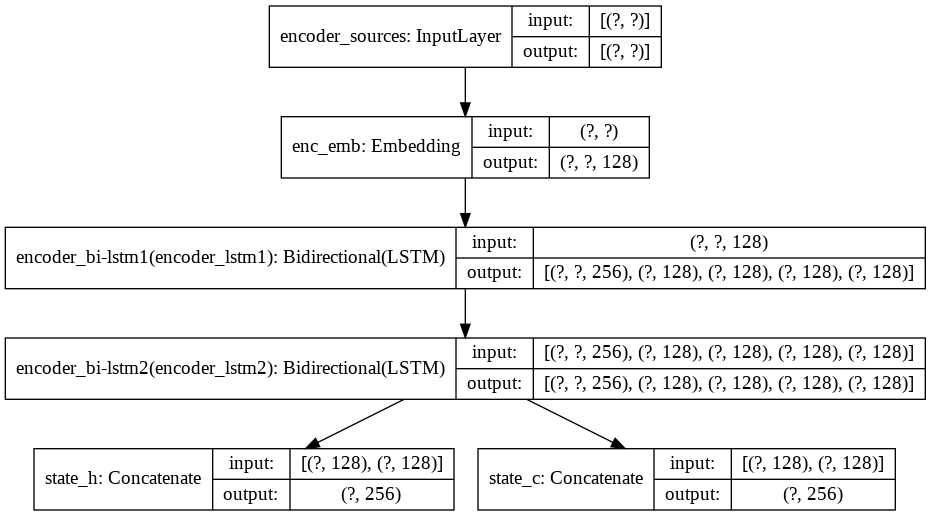

In [ ]:
# this is the target languge consumtion layer
decoder_inputs = Input(shape=(None,), name='decoder_sources')
# embed the 2-d source into 3-d
dec_emb_layer = Embedding(len(target_vocab)+1, embedding_dim, mask_zero = True, name='dec_emb_layer')
dec_emb = dec_emb_layer(decoder_inputs)

# decoder LSTM, this takes in the context-vector and starting or so-far decoded part of the target sentence
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, name='decoder_lstm1', dropout=dropout)
decoder_outputs11 = decoder_lstm1(dec_emb)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, name='decoder_lstm2', dropout=dropout)
decoder_outputs12 = decoder_lstm2(decoder_outputs11)
decoder_lstm3 = LSTM(latent_dim*2, return_sequences=True, return_state=True, name='decoder_lstm', dropout=dropout)
decoder_outputs13, _, _ = decoder_lstm3(decoder_outputs12, initial_state=encoder_states)

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, _ = attn_layer([encoder_outputs, decoder_outputs13])

# Concate attention with decoder
Concatenation_layer=Concatenate(axis=-1, name='Concatenate_AttentionDecoder')
attended_decoder_outputs = Concatenation_layer([decoder_outputs13, attn_out])

# final layer that gives a probabilty distribution of the next possible words
decoder_dense = Dense(len(target_vocab)+1, activation='softmax', name='decoder_dense')
decoder_outputs14 = decoder_dense(attended_decoder_outputs)

# Encode the source sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states], name='Model_Encoder')
encoder_model.summary()
plot_model(encoder_model, show_shapes=True, show_layer_names=True)

# Custom Loss Function and accuracy to get rid of padding

In [ ]:
vocab_len=len(onehotted_decoder_output_arr[0][0])

def PaddedCategoricalCrossentropy(eps=1e-12):
  def loss(y_true, y_pred):
      mask_value = np.zeros((vocab_len))
      mask_value[0] = 1
      # find out which timesteps in `y_true` are not the padding character 
      mask = K.equal(y_true, mask_value)
      mask = 1 - K.cast(mask, K.floatx())
      mask = K.sum(mask,axis=2)/2
      # multplying the loss by the mask. the loss for padding will be zero
      loss = tf.keras.layers.multiply([K.categorical_crossentropy(y_true, y_pred), mask])
      return K.sum(loss) / K.sum(mask)
  return loss


def word_acc(y_true, y_pred):
  mask_value = np.zeros((vocab_len))
  mask_value[0] = 1
  # find out which timesteps in `y_true` are not the padding character 
  mask = K.equal(y_true, mask_value)
  mask = 1 - K.cast(mask, K.floatx())
  mask = K.sum(mask,axis=2)/2
  # multplying the loss by the mask. the loss for padding will be zero
  acc = tf.keras.layers.multiply([tf.keras.metrics.categorical_accuracy(y_true, y_pred), mask])
  return K.sum(acc) / K.sum(mask)

Model: "Model_Translation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_sources (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_sources (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, None, 128)    771968      encoder_sources[0][0]            
__________________________________________________________________________________________________
dec_emb_layer (Embedding)       (None, None, 128)    362752      decoder_sources[0][0]            
__________________________________________________________________________________

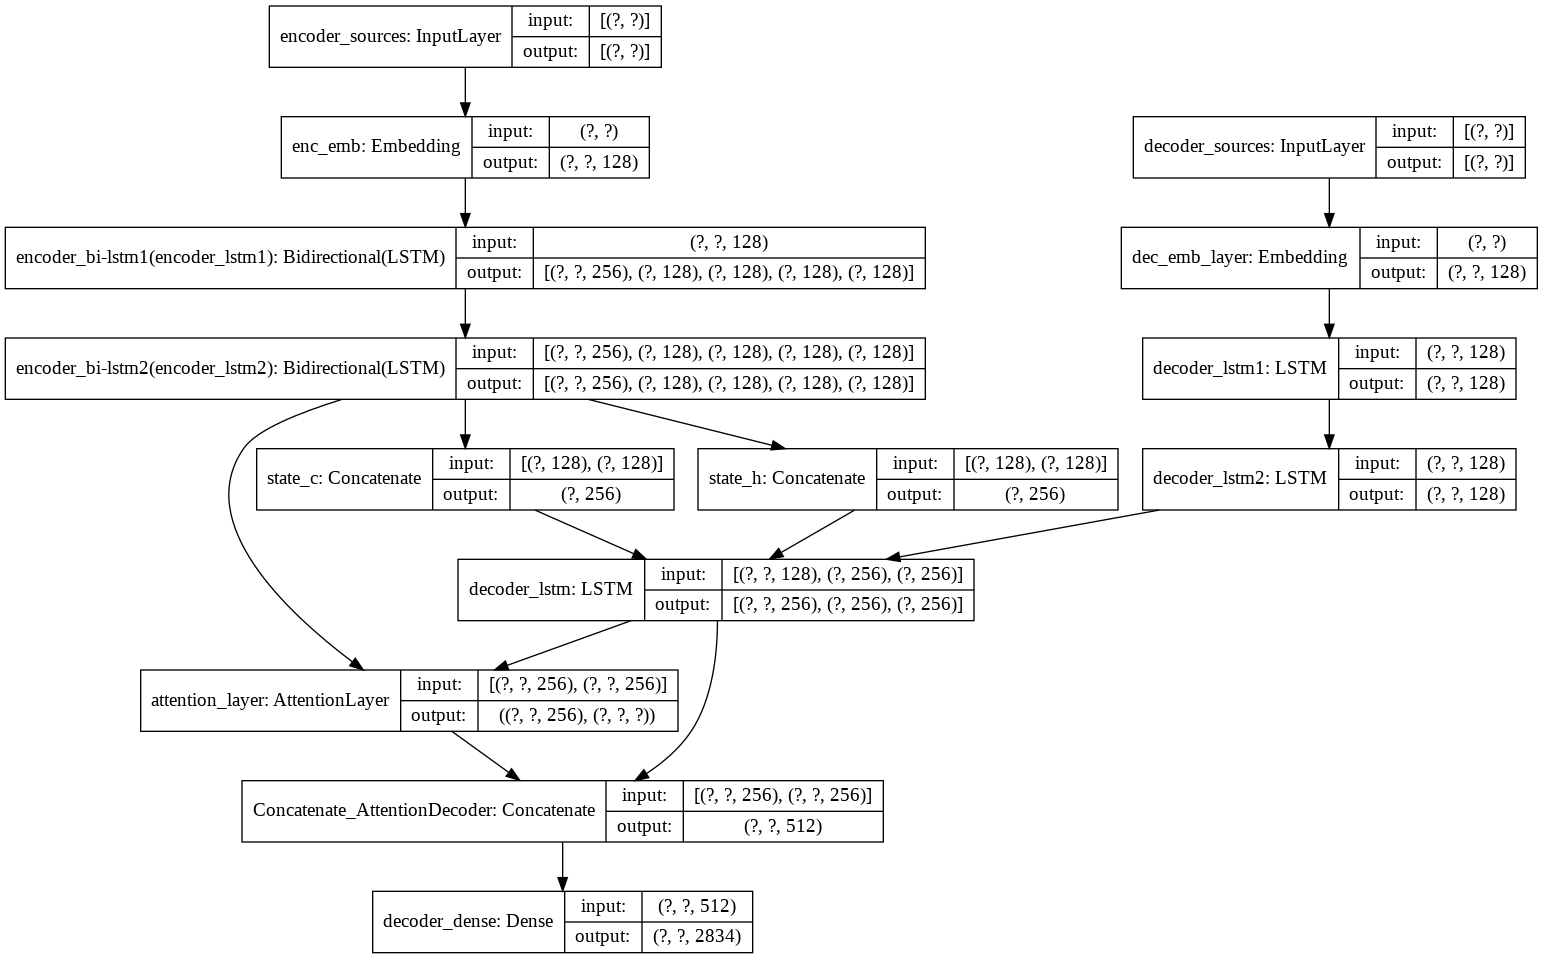

In [ ]:
# model building and summary
model = Model([encoder_inputs, decoder_inputs], decoder_outputs14, name='Model_Translation')
model.compile(optimizer='Adam', loss=PaddedCategoricalCrossentropy(), metrics=[word_acc])
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# Training

In [ ]:
# TensorBoard Callback 
tbCallBack = TensorBoard(log_dir=os.path.join(root_dir, 'Graph'), histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
if training:
    # train the model
    history=model.fit([padded_encoder_source_arr, padded_decoder_source_arr], shuffle=True, onehotted_decoder_output_arr, epochs=epochs, validation_split=0.02, callbacks=[tbCallBack], batch_size=batch_size)

Epoch 1/300
8/8 [==============================] - 5s 591ms/step - loss: 0.0212 - word_acc: 0.9839 - val_loss: 1.2029 - val_word_acc: 0.7956
Epoch 2/300
8/8 [==============================] - 4s 487ms/step - loss: 0.0210 - word_acc: 0.9841 - val_loss: 1.1974 - val_word_acc: 0.7950
Epoch 3/300
8/8 [==============================] - 4s 493ms/step - loss: 0.0210 - word_acc: 0.9840 - val_loss: 1.1924 - val_word_acc: 0.7962
Epoch 4/300
8/8 [==============================] - 4s 493ms/step - loss: 0.0210 - word_acc: 0.9841 - val_loss: 1.1935 - val_word_acc: 0.7944
Epoch 5/300
8/8 [==============================] - 4s 489ms/step - loss: 0.0211 - word_acc: 0.9841 - val_loss: 1.2100 - val_word_acc: 0.7894
Epoch 6/300
8/8 [==============================] - 4s 485ms/step - loss: 0.0210 - word_acc: 0.9838 - val_loss: 1.2107 - val_word_acc: 0.7900
Epoch 7/300
8/8 [==============================] - 4s 482ms/step - loss: 0.0207 - word_acc: 0.9841 - val_loss: 1.2165 - val_word_acc: 0.7900
Epoch 8/300
8

KeyboardInterrupt: ignored

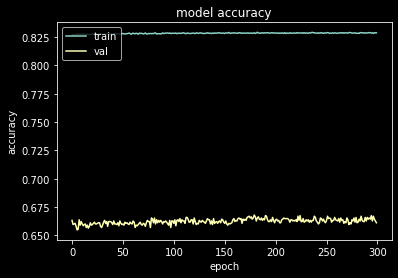

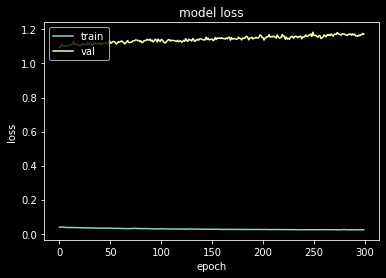

1/1 [==============================] - 0s 2ms/step - loss: 1.2231 - word_acc: 0.7887
Accuracy while saving is [1.223084807395935, 0.7887499928474426]


In [ ]:
if training:
    model.save_weights(os.path.join(root_dir, weight_file))
    with plt.style.context('dark_background'):
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    print(f'Accuracy while saving is {model.evaluate([padded_encoder_source_arr, padded_decoder_source_arr], onehotted_decoder_output_arr)}')

# Decoder Model

Model: "Model_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_sources (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_emb_layer (Embedding)       (None, None, 128)    362752      decoder_sources[0][0]            
__________________________________________________________________________________________________
decoder_lstm1 (LSTM)            (None, None, 128)    131584      dec_emb_layer[2][0]              
__________________________________________________________________________________________________
decoder_lstm2 (LSTM)            (None, None, 128)    131584      decoder_lstm1[2][0]              
______________________________________________________________________________________

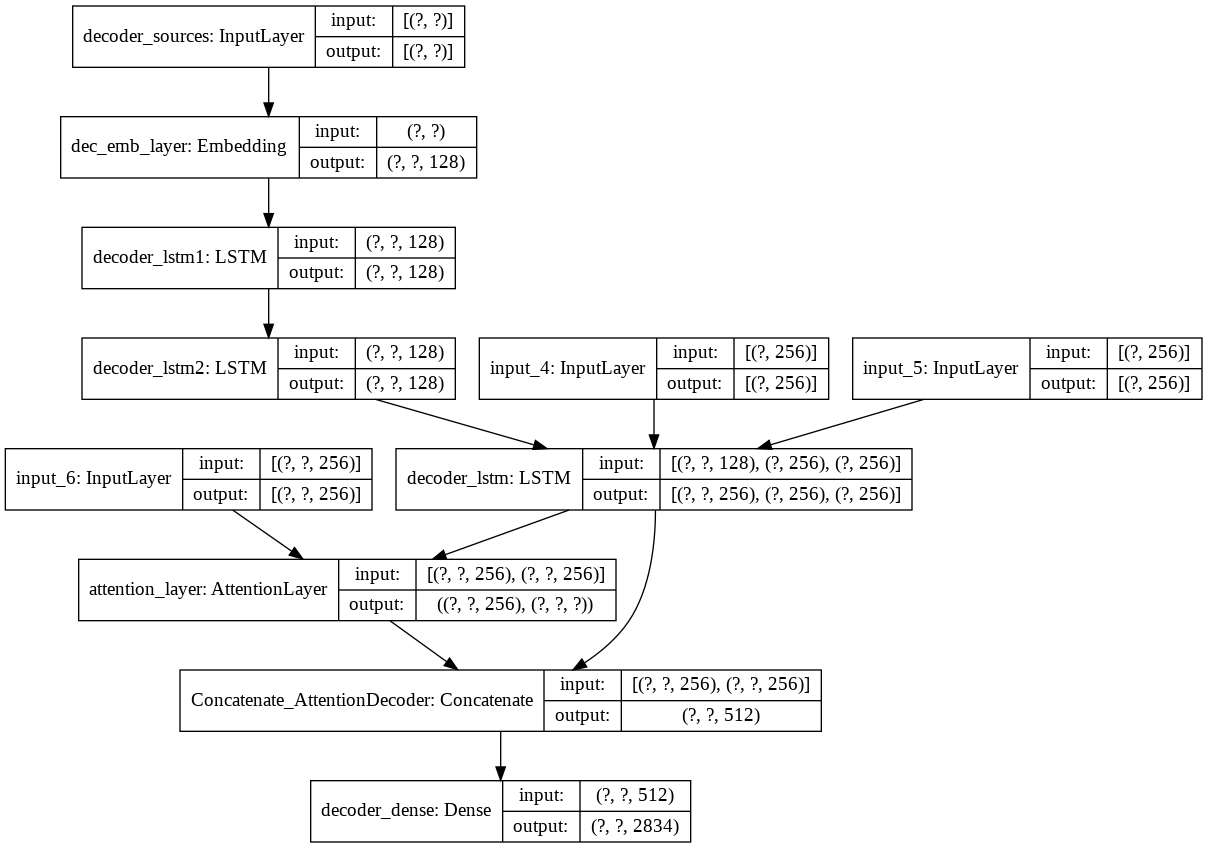

In [ ]:
# Decoder setup
# Below tensors will hold the states of the previous time step
state_h = Input(shape=(latent_dim*2,))
state_c = Input(shape=(latent_dim*2,))
decoder_inputsFrom_encoder = Input(shape=(None, latent_dim*2,))
decoder_state_input = [state_h, state_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs21 = decoder_lstm1(dec_emb2)
decoder_outputs22 = decoder_lstm2(decoder_outputs21)
decoder_outputs23, state_h2, state_c2 = decoder_lstm3(decoder_outputs22, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]

# attention
attn_out1, _ = attn_layer([decoder_inputsFrom_encoder, decoder_outputs23])
attended_decoder_outputs1 = Concatenation_layer([decoder_outputs23, attn_out1])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs24 = decoder_dense(attended_decoder_outputs1)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_inputsFrom_encoder] + decoder_state_input,
    [decoder_outputs24] + decoder_states2, 
    name='Model_Decoder')
decoder_model.summary()
plot_model(decoder_model, show_shapes=True, show_layer_names=True)

# Decoding Logic

In [ ]:
def decode_sequence(source_seq):
    
    # Encode the source as state vectors.
    encoder_values, states_value = encoder_model.predict(source_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = target_wordint_rel.inv['START_']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encoder_values] + states_value)
    # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_wordint_rel[sampled_token_index]
        decoded_sentence += [sampled_word]
    # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
    # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
    # Update states
        states_value = [h, c]

    return decoded_sentence

# Prediction

In [ ]:
start=10
offset=10
def calc_strdiff(true, pred):
    # return sum([1 for char in list(difflib.ndiff(true, pred)) if '+ ' in char or '- ' in char])/(len(true))
    return  nltk.translate.bleu_score.sentence_bleu([word_tokenize(true)[:-1]], word_tokenize(pred)[:-1])
    
if validation:
    
    model.load_weights(os.path.join(root_dir, weight_file))
    print(f'Accuracy after loading is {model.evaluate([padded_encoder_source_arr, padded_decoder_source_arr], onehotted_decoder_output_arr)}')
    y_truePred = [(' '.join(source_sents[seq_index][:-1]), ' '.join(target_sents[seq_index][1:-1]), ' '.join(decode_sequence(padded_encoder_source_arr[seq_index:seq_index+1])[:-1])) for seq_index, _ in enumerate(padded_encoder_source_arr[start:start+offset], start)]
    y_truePred=[(src, true, pred, calc_strdiff(true, pred)) for src, true, pred, in y_truePred]
    df=pd.DataFrame(y_truePred, columns=['Source', 'Expected', 'Predicted', 'Bleu Score'])
    print(f'Avg bleu score for {len(df)} tests was {df["Bleu Score"].sum()/len(df)}.')
    print(f"{df.to_string()}")
    df.to_excel(os.path.join(root_dir, 'review.xlsx'), index=False)

469/469 [==============================] - 9s 18ms/step - loss: 0.0418 - acc: 0.8263
Accuracy after loading is [0.04177983105182648, 0.8263205289840698]
Avg bleu score for 10 tests was 0.8263324692151306.
                       Source             Expected                Predicted  Bleu Score
0             tom est resté .         tom stayed .        tom stayed stayed    1.000000
1  vous faites des manières .      you are fussy .      you are you fussy .    0.707107
2          vous êtes maline .     you are clever .     you are you clever .    0.707107
3             tu es bizarre .      you are weird .          you are are odd    0.759836
4          il laissa tomber .            he quit .                he quit .    1.000000
5        allez-y maintenant .             go now .              go now go .    0.759836
6           il a été lapidé .      he was stoned .          he was stoned .    1.000000
7      j'ai besoin d'un ami .    i need a friend .      i need got a friend    0.707107
8  

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
